# SARIMA (Seasonal Autoregressive Integrated Moving Average)

Time series data is all around us, from stock prices and weather patterns to demand forecasting and seasonal trends in sales. To make sense of this data and predict future values, we turn to powerful models like the Seasonal Autoregressive Integrated Moving Average, or SARIMA. In this notebook, we will unravel the mysteries of SARIMA models to forecast stock prices.

## Understanding SARIMA
SARIMA, which stands for Seasonal Autoregressive Integrated Moving Average, is a versatile and widely used time series forecasting model. It’s an extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns. SARIMA captures both short-term and long-term dependencies within the data, making it a robust tool for forecasting. It combines the concepts of autoregressive (AR), integrated (I), and moving average (MA) models with seasonal components.

## The Components of SARIMA
To grasp SARIMA, let’s break down its components:

1. **Seasonal Component**: The “S” in SARIMA represents seasonality, which refers to repeating patterns in the data. This could be daily, monthly, yearly, or any other regular interval. Identifying and modeling the seasonal component is a key strength of SARIMA.
2. **Autoregressive (AR) Component**: The “AR” in SARIMA signifies the autoregressive component, which models the relationship between the current data point and its past values. It captures the data’s autocorrelation, meaning how correlated the data is with itself over time.
3. **Integrated (I) Component**: The “I” in SARIMA indicates differencing, which transforms non-stationary data into stationary data. Stationarity is crucial for time series modeling. The integrated component measures how many differences are required to achieve stationarity.
4. **Moving Average (MA) Component**: The “MA” in SARIMA represents the moving average component, which models the dependency between the current data point and past prediction errors. It helps capture short-term noise in the data.
5. **Seasonal Differencing**: Before we jump into SARIMA, it’s essential to understand seasonal differencing. Seasonal differencing is the process of subtracting the time series data by a lag that equals the seasonality. This helps remove the seasonal component and makes the data stationary, allowing for more straightforward modeling. Seasonal differencing is often denoted as “D” in SARIMA.

## The SARIMA Notation
SARIMA(p, d, q)(P, D, Q, s):
- **AR(p)**: Autoregressive component of order p
- **MA(q)**: Moving average component of order q
- **I(d)**: Integrated component of order d
- **Seasonal AR(P)**: Seasonal autoregressive component of order P
- **Seasonal MA(Q)**: Seasonal moving average component of order Q
- **Seasonal I(D)**: Seasonal integrated component of order D
- **s**: Seasonal period

In the next sections, we will explore how to implement a SARIMA model to forecast stock prices, including data preparation, model fitting, and evaluation.

### Step 1: Import Libraries

In [ ]:
# Standard Libraries
from math import sqrt

# Data Manipulation and Analysis Libraries
import numpy as np
import pandas as pd

# Data Visualization Libraries
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# Statistical and Time Series Analysis Libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning and Forecasting Libraries
import pmdarima as pm
from sktime.split import temporal_train_test_split

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Step 2: Load Dataset
let’s use this time stock dataset of tsla from '2015-01-01' to '2024-10-31', to predict the stock price monthly sales.

In [3]:
bnd_df = pd.read_csv('../../data/cleaned/cleaned_BND.csv')
bnd_df = bnd_df[['Date', 'Adj Close']]
# Convert the 'Date' column to datetime
bnd_df['Date'] = pd.to_datetime(bnd_df['Date'])
bnd_df = bnd_df.set_index(bnd_df['Date']).drop('Date', axis=1)
bnd_df.head()

,Adj Close
Date,
2015-01-02 00:00:00+00:00,82.430000
2015-01-05 00:00:00+00:00,82.739998
2015-01-06 00:00:00+00:00,83.029999
2015-01-07 00:00:00+00:00,83.139999
2015-01-08 00:00:00+00:00,83.110001


The statsmodels library requires that our dataframe have an explicit temporality, so resample the data with 'MS' to ensure that the dataframe knows that the data is using a Month Start interval.

In [4]:
# Resample to monthly Adj closing prices (last observation)
bnd_df = bnd_df.resample('MS').last()
# Alternatively, use the mean price
# monthly_close = tesla_data['Close'].resample('M').mean()

In [5]:
bnd_df.head()

,Adj Close
Date,
2015-01-01 00:00:00+00:00,84.199997
2015-02-01 00:00:00+00:00,83.029999
2015-03-01 00:00:00+00:00,83.300003
2015-04-01 00:00:00+00:00,82.690002
2015-05-01 00:00:00+00:00,82.419998


### Step 3: Plotting the Monthly Adj Closing Stock Price

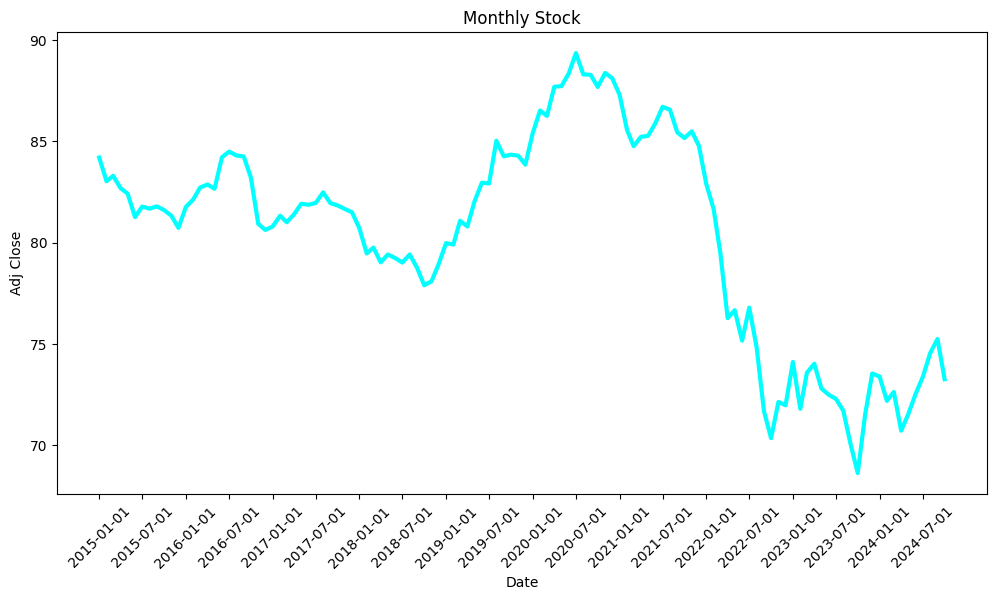

In [6]:
plt.figure(figsize=(12, 6)) 
plt.plot(bnd_df, linewidth=3,c='cyan') 
plt.title("Monthly Stock") 
plt.xlabel("Date") 
plt.xticks(ticks=bnd_df.index[::6], rotation=45)  # Show every 6th month
plt.ylabel("Adj Close") 
plt.show()

### Step 4: Check Stationarity
Before applying SARIMA, let's check if our time series data is stationary because SARIMA assumes that the time series data is stationary. Stationarity refers to the statistical properties of a time series remaining constant over time, such as constant mean, constant variance, and constant autocovariance. We can use the Dickey-Fuller test for this.

In [ ]:
def check_stationarity(timeseries): 
    # Perform the Dickey-Fuller test 
    adf_result = adfuller(timeseries.dropna(), autolag='AIC') 
    adf_statistic = adf_result[0]
    adf_p_value = adf_result[1]
    
    # Perform the KPSS test
    kpss_result = kpss(timeseries.dropna(), regression='c')  # 'c' for constant, 'ct' for trend
    kpss_statistic = kpss_result[0]
    kpss_p_value = kpss_result[1]

    # Print results
    print(f'ADF Statistic: {adf_statistic}') 
    print(f'ADF p-value: {adf_p_value}') 
    print('ADF Test Result: Stationary' if adf_p_value < 0.05 else 'ADF Test Result: Non-Stationary')
    
    print(f'KPSS Statistic: {kpss_statistic}') 
    print(f'KPSS p-value: {kpss_p_value}') 
    print('KPSS Test Result: Stationary' if kpss_p_value > 0.05 else 'KPSS Test Result: Non-Stationary')

# Example usage with your DataFrame
check_stationarity(bnd_df['Adj Close'])

ADF Statistic: -0.8333430001665857
ADF p-value: 0.809131111871952
ADF Test Result: Non-Stationary
KPSS Statistic: 0.6573632953679973
KPSS p-value: 0.017421518602909334
KPSS Test Result: Non-Stationary


### Step 5: Identify Model Parameters
Identify the SARIMA model parameters (p, d, q, P, D, Q, s) using ACF and PACF plots.

* ACF Plot: This function generates an ACF plot, which is a plot of autocorrelations of the differenced time series. Autocorrelation measures the relationship between a data point and previous data points at different lags.
* PACF Plot: This function generates a PACF plot, which is a plot of partial autocorrelations of the differenced time series. Partial autocorrelation represents the correlation between a data point and a lag while adjusting for the influence of other lags.

In [ ]:
# Plot ACF and PACF 
train, test = temporal_train_test_split(bnd_df, test_size=36)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

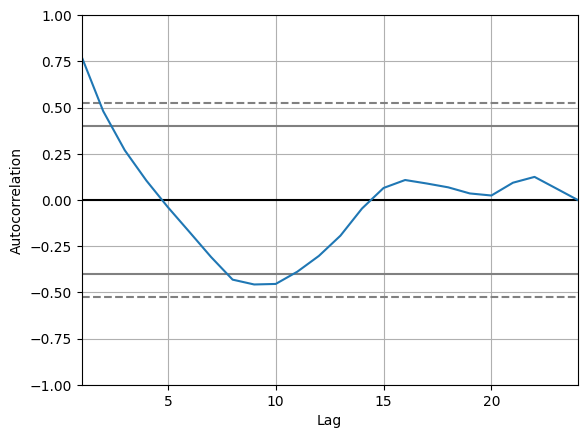

In [ ]:
autocorrelation_plot(train[-24:])

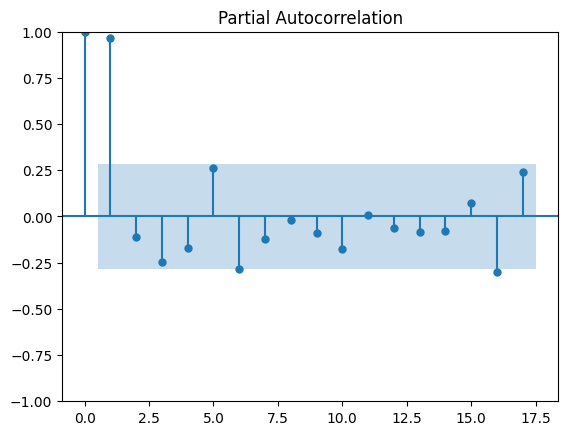

In [ ]:
plot_pacf(train[-48:])
plt.show()

In [ ]:
auto_model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      m=12, # frequency of series
                      d=None, # let model determine 'd'
                      seasonal=True, # Use Seasonality
                      information_criterion='aicc',
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

In [ ]:
# Print the best parameters
best_order = auto_model.order  # (p, d, q)
best_seasonal_order = auto_model.seasonal_order  # (P, D, Q, s)

print(f"Best parameters:")
print(f"p: {best_order[0]}")
print(f"d: {best_order[1]}")
print(f"q: {best_order[2]}")
print(f"P: {best_seasonal_order[0]}")
print(f"D: {best_seasonal_order[1]}")
print(f"Q: {best_seasonal_order[2]}")
print(f"s: {best_seasonal_order[3]}")

Best parameters:
p: 0
d: 1
q: 0
P: 0
D: 0
Q: 0
s: 12


In [24]:
# Define SARIMA parameters 
p, d, q = 0, 1, 0
P, D, Q, s = 0, 0, 0, 12  # Assuming monthly seasonality 
  
# Fit the SARIMA model 
model = SARIMAX(bnd_df, order=(p, d, q), seasonal_order=(P, D, Q, s)) 
results = model.fit() 
model 

### Step 7: Generate Forecasts
With the model fitted, generate forecasts for future time periods.

In this section of the code, we are using the SARIMA model to forecast future sales values. We specify that we want to forecast the next 12 months by setting forecast_periods to 12.
The results.get_forecast(steps=forecast_periods) function generates the forecast, providing both the predicted mean and a confidence interval for the forecasted values.

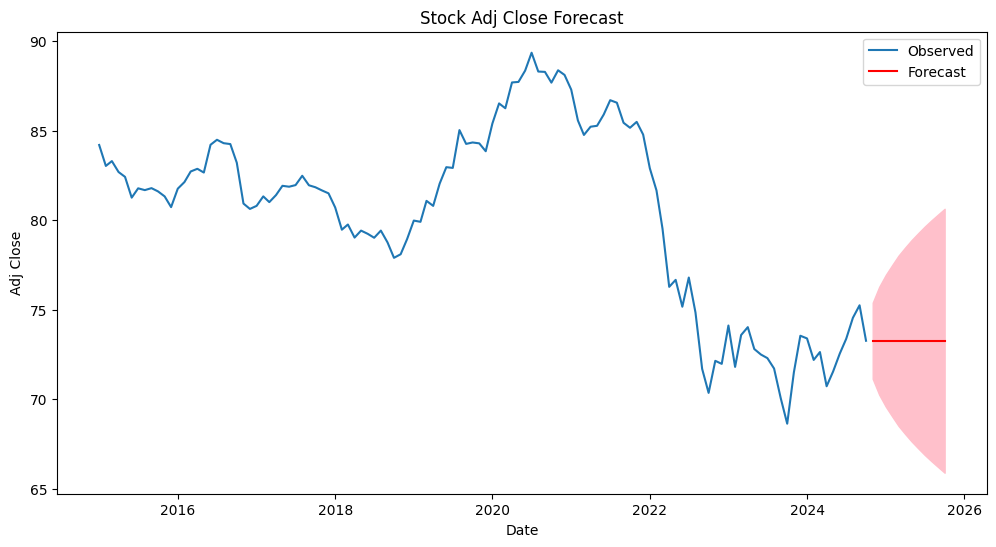

In [25]:
# Forecast future values 
forecast_periods = 12 # Forecast the next 12 months 
forecast = results.get_forecast(steps=forecast_periods) 
forecast_mean = forecast.predicted_mean 
forecast_ci = forecast.conf_int() 

# Plot the forecast 
plt.figure(figsize=(12, 6)) 
plt.plot(bnd_df, label='Observed') 
plt.plot(forecast_mean, label='Forecast', color='red') 
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink') 
plt.title("Stock Adj Close Forecast") 
plt.xlabel("Date") 
plt.ylabel("Adj Close") 
plt.legend() 
plt.show()


The observed sales data and the forecasted values in red. The pink shaded area represents the confidence interval around the forecast. This visualization helps us understand the expected future sales trends based on our SARIMA model.

### Step 8: Evaluate the Model
Let’s evaluate the forecasted sales values by comparing them to the observed sales data using two common metrics for this evaluation: Mean Absolute Error (MAE) and Mean Squared Error (MSE).

MAE (Mean Absolute Error) measures the average absolute difference between the observed and forecasted values. It provides a simple and easily interpretable measure of the model’s accuracy.
MSE (Mean Squared Error) measures the average of the squared differences between the observed and forecasted values. MSE gives more weight to large errors and is sensitive to outliers.
Lower values indicate better performance.

In [ ]:
observed = bnd_df[-forecast_periods:] 
rmse = sqrt(mean_squared_error(observed, forecast_mean))
mae = mean_absolute_error(observed, forecast_mean) 
mse = mean_squared_error(observed, forecast_mean) 
print('Test RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae) 
print('MSE: %.3f' % mse)

Test RMSE: 1.299
MAE: 1.018
MSE: 1.686


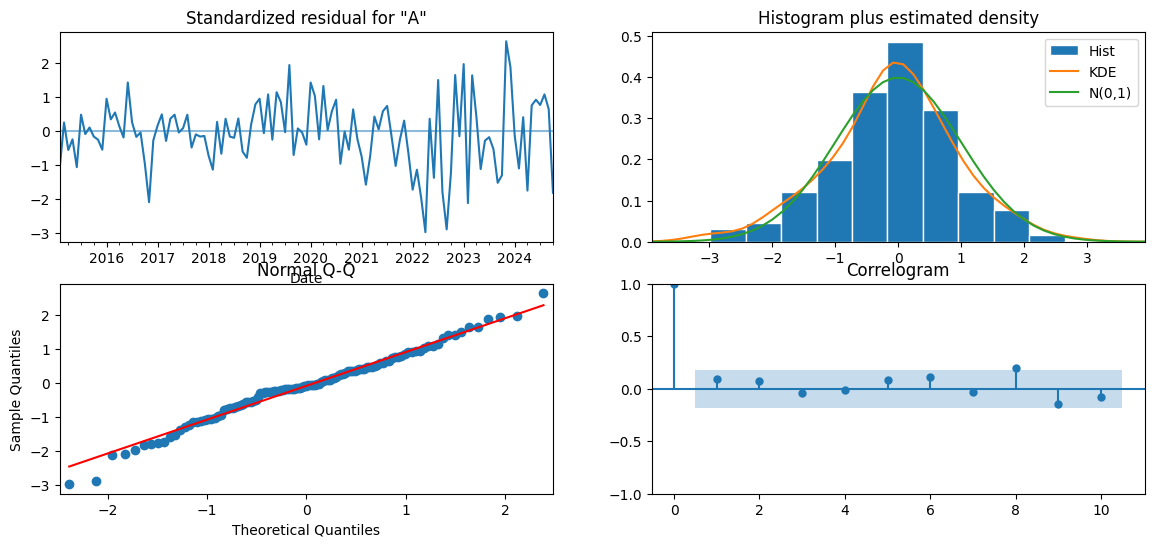

In [27]:
results.plot_diagnostics(figsize=(14, 6))
plt.show()

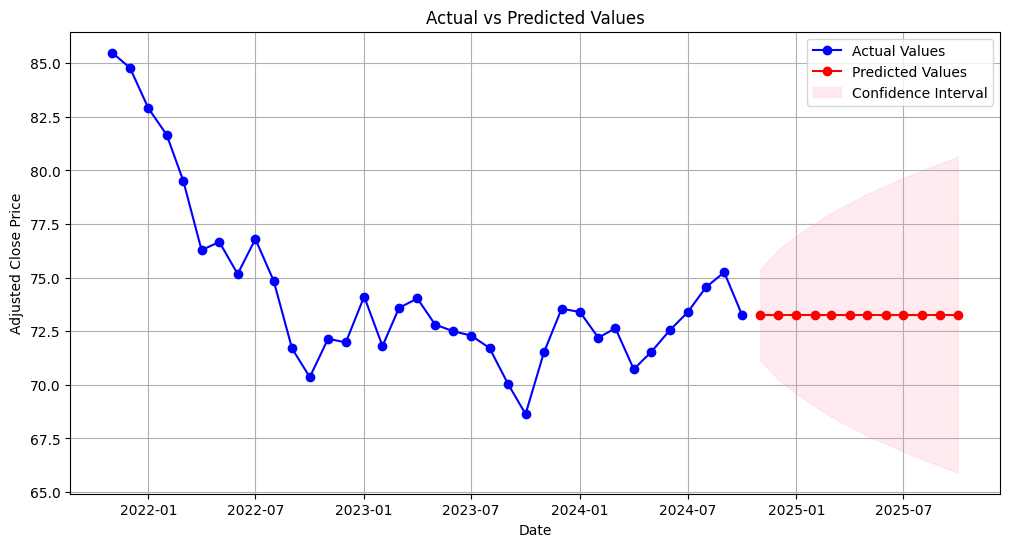

In [28]:
# Extract the actual values from the test set
observed = test['Adj Close']  # Replace 'Adj_Close' with the actual column name if different

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, observed, label='Actual Values', color='blue', marker='o')
plt.plot(forecast_mean.index, forecast_mean, label='Predicted Values', color='red', marker='o')

# Optionally, plot the confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title("Actual vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid()
plt.show()